# Ensemble Learning & Random Forests

![forest image](./images/Forest.PNG)

## Table of Contents

---

### 1. [Ensemble Learning](#Ensemble-Learning)
### 2. [Voting Classifiers](#Voting-Classifiers)
### 3. [Bagging & Pasting](#Bagging-&-Pasting)
### 4. [Boosting](#Boosting)
### 5. [Stacking](#Stacking)

---


## Setup

In [10]:
import pandas as pd

# To split dataset for testing and training
from sklearn.model_selection import train_test_split

# Dataset used for binary classification
from sklearn.datasets import make_moons

# Metrics
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Ensemble Learning

Ensemble learning is when you **put together** trained models instead of picking just one.

### There are four main ensemble methods:
### 1. Voting
### 2. Bagging/Pasting
### 3. Boosting
### 4. Stacking

## Voting Classifiers

![voting image](./images/voting.jpg)

- Train **many models** on **all** the training data, then select the best
- Let the models *'vote'* on the classification
- The **majority**, or most agreed on answer is your classification

In [11]:
# Ensemble Model for Voting
from sklearn.ensemble import VotingClassifier

# Individual Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### We are going to make a voting classifier that looks like this:
![Diagram of Voting Classifier Configuration](./images/votingclf_config.PNG)

In [12]:
# Three Individual Classification Models
logistic_classifier = LogisticRegression(solver="liblinear", random_state=42)
random_forest_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
support_vector_classifier = SVC(gamma="auto", random_state=42, probability=True)

In [13]:
# One Voting Classifier to Aggregate Them
hard_voting_classifier = VotingClassifier(
    estimators = [
        ('lr', logistic_classifier), 
        ('rf', random_forest_classifier), 
        ('svc', support_vector_classifier)
    ],
    voting = 'hard' # hard OR soft
)

soft_voting_classifier = VotingClassifier(
    estimators = [
        ('lr', logistic_classifier), 
        ('rf', random_forest_classifier), 
        ('svc', support_vector_classifier)
    ],
    voting = 'soft'
)

## Two Types of Voting
### Hard
- Take the highest number of votes

### Soft
- Add up the probabilities to pick the one that we are most sure about

#### Example of Hard Voting
![Diagram of Voting Classifier Configuration](./images/votingclf.PNG)


In [14]:
voting_results = pd.DataFrame()

for clf in ( logistic_classifier, random_forest_classifier, support_vector_classifier, 
            hard_voting_classifier, soft_voting_classifier):
    
    # Train our models on the training data
    clf.fit(X_train, y_train)
    
    # Evaluate their performance using the testing data
    y_pred = clf.predict(X_test)
    
    name = type(clf).__name__
    if name == 'VotingClassifier':
        name = name + ' ' + clf.voting
    
    # Store our accuracy results in a dataframe
    model_result = { 'Model': name, 'Accuracy': accuracy_score(y_test, y_pred) }
    voting_results = voting_results.append(model_result, ignore_index=True)

Text(0, 0.5, 'Model\n')

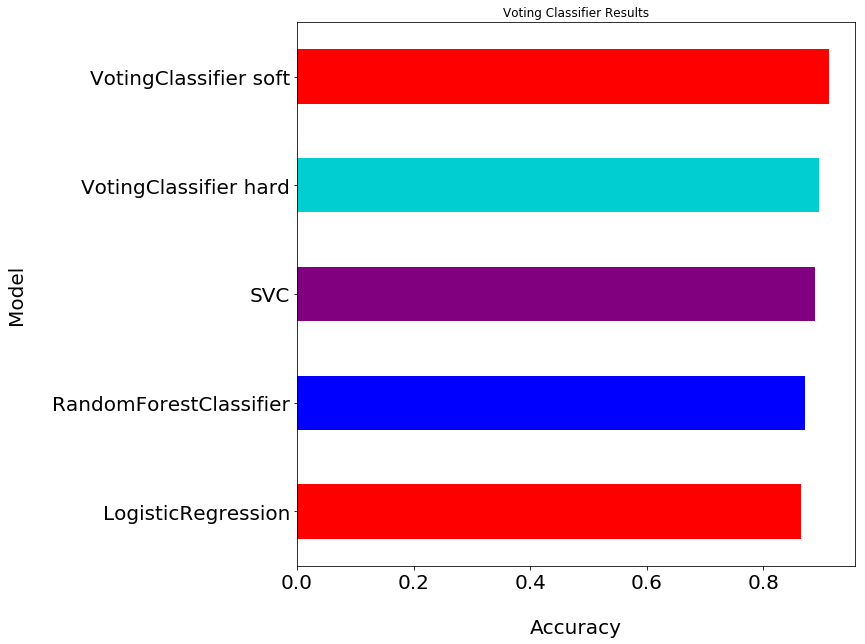

In [15]:
colors = ['r', 'b', 'purple', 'darkturquoise']

barchart = voting_results.sort_values(by='Accuracy', ascending=True).plot.barh('Model', 
                                    'Accuracy', 
                                    color=colors, 
                                    fontsize=20, 
                                    title='Voting Classifier Results',
                                    legend=False,
                                    figsize=(10,10))

barchart.set_xlabel('\nAccuracy', fontsize=20)
barchart.set_ylabel('Model\n', fontsize=20)

In [16]:
voting_results.sort_values(by='Accuracy', ascending=False)

,Accuracy,Model
4,0.912,VotingClassifier soft
3,0.896,VotingClassifier hard
2,0.888,SVC
1,0.872,RandomForestClassifier
0,0.864,LogisticRegression


## Bagging & Pasting

- Select **one** model type
- Train many models of that type on **random subsets** of the data
- Let the models *'vote'* on the classification (soft or hard like our voting classifiers)
- The **majority**, or most agreed on answer is your classification

### Terminology

**Bagging (Bootstrap Aggregating)**: When the sampled data is put back, giving other models a chance to sample it

**Pasting** When the sampled data is removed, so no model see's it more than once

### So lets train a bagging classifier on our data

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Pick our model type for the bagging classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# Define our Bagging Classifier
bag_clf = BaggingClassifier(
    decision_tree_classifier,
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42)

# Train the ensemble model, and our lone model to see how it compares
bag_clf.fit(X_train, y_train)
decision_tree_classifier.fit(X_train, y_train)

# Evaluate their accuracy
y_pred_bag = bag_clf.predict(X_test)
y_pred_control = decision_tree_classifier.predict(X_test)

In [18]:
# Store our accuracy results in a dataframe
model_result = { 'Model': type(bag_clf).__name__, 'Accuracy': accuracy_score(y_test, y_pred_bag) }
voting_results = voting_results.append(model_result, ignore_index=True)

model_result = { 'Model': type(decision_tree_classifier).__name__, 'Accuracy': accuracy_score(y_test, y_pred_control) }
voting_results = voting_results.append(model_result, ignore_index=True)

Text(0, 0.5, 'Model\n')

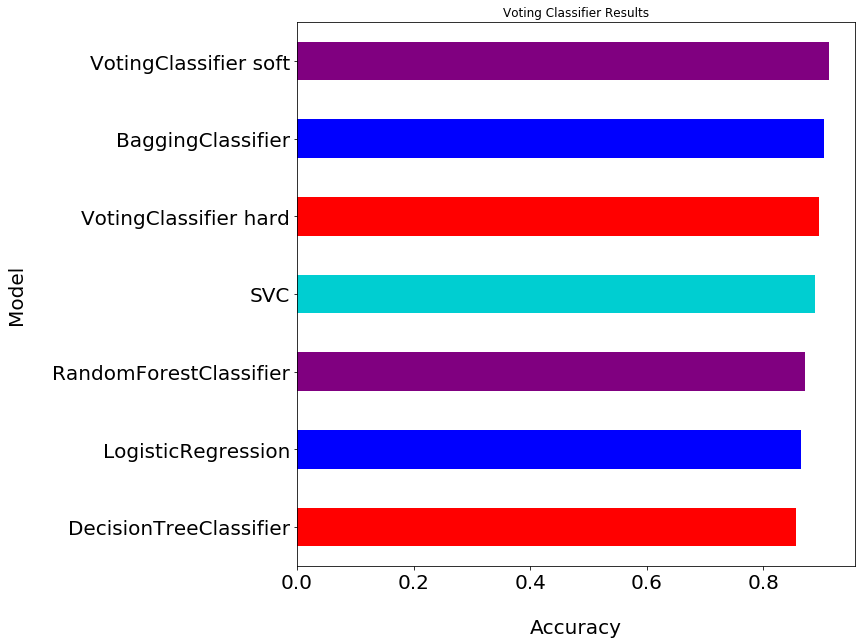

In [19]:
barchart = voting_results.sort_values(by='Accuracy', ascending=True).plot.barh('Model', 
                                    'Accuracy', 
                                    color=colors, 
                                    fontsize=20, 
                                    title='Voting Classifier Results',
                                    legend=False,
                                    figsize=(10,10))

barchart.set_xlabel('\nAccuracy', fontsize=20)
barchart.set_ylabel('Model\n', fontsize=20)

In [20]:
voting_results.sort_values(by='Accuracy', ascending=False)

,Accuracy,Model
4,0.912,VotingClassifier soft
5,0.904,BaggingClassifier
3,0.896,VotingClassifier hard
2,0.888,SVC
1,0.872,RandomForestClassifier
0,0.864,LogisticRegression
6,0.856,DecisionTreeClassifier


### Random Forests

### The bagging classifier we just made is a special type of ensemble. 
A **Random Forest Tree** is an ensemble of decision tree's made from bagging or pasting. We made one using the built in RandomForestClassifier class in the voting section as well.

## Boosting

- Train a model
- Identify the models mistakes
- Feed the mistakes to a new model that is trained to fix the last ones mistakes
- Repeat, chaining together a sequence of improving models
- The result is a bunch of models that add together their predictions to give one answer

### Types of Boosting
- **AdaBoost:** Have "importance" weights on the data. When a classifier gets one wrong, increase its weight for the next classifier in the chain. The way we do this is using a **weighted error** to measure our performance instead of the mean error.


![Adaboost Weighted Error Equation](./images/weighted_error_adaboost.PNG)

- **Gradient Boosting:** Instead of assigning weights to each instance of data, gradient boosting will try to fit the next model to the residual errors of the previous predictor

![Adaboost Weighted Error Equation](./images/gradient_boost1.PNG)
![Adaboost Weighted Error Equation](./images/gradient_boost2.PNG)

### Train an AdaBoost Model

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

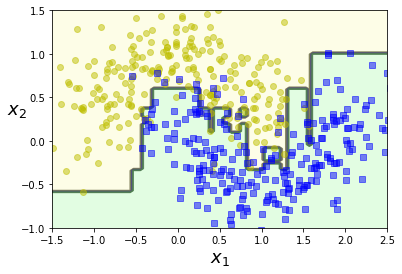

<Figure size 1440x1440 with 0 Axes>

In [31]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
adaboost_clf.fit(X_train, y_train)

plot_decision_boundary(adaboost_clf, X, y)

## Stacking

### Why choose hard or soft voting when we can train a model to make the decision?

In stacking you feed all the model outputs from an ensemble method like bagging or voting into another model that is trained to pick the correct answer based on the other models behavior.

![Diagram of Voting Classifier Configuration](./images/stacking.PNG)

### Stacking isn't supported in Scikit Learn yet so I don't have an example for you!